In [ ]:
'''
Signals Project, Deliverable #2
 
BME 252 - Linear Systems and Signals
 
Sunny Willert 20619549
Vincent Shadbolt 20617236
Samantha Feng 20604727
 
June 22, 2017
 
'''

In [3]:
import pandas as pd
import numpy as np
import scipy as sp
from scipy import integrate as itg
from scipy import signal
from matplotlib import pyplot as plt

In [4]:
# import data, remove unnecessary cells
data = pd.read_csv('C:\\Users\\Sam\\Documents\\Signals\\sunny_1.csv', header=0)
del data['Unnamed: 7']

# create dataframes for angles
int_1 = pd.DataFrame(columns=['time','wx_1','wy_1','wz_1'])

In [5]:
# integrate angular velocity signal for angle

for _dir in ['x', 'y', 'z']:
    for _type in ['w']:
        int_1['{}{}_1'.format(_type, _dir)] = itg.cumtrapz(data['{}{}'.format(_type, _dir)], data['time'])
        int_1['time'] = data['time']

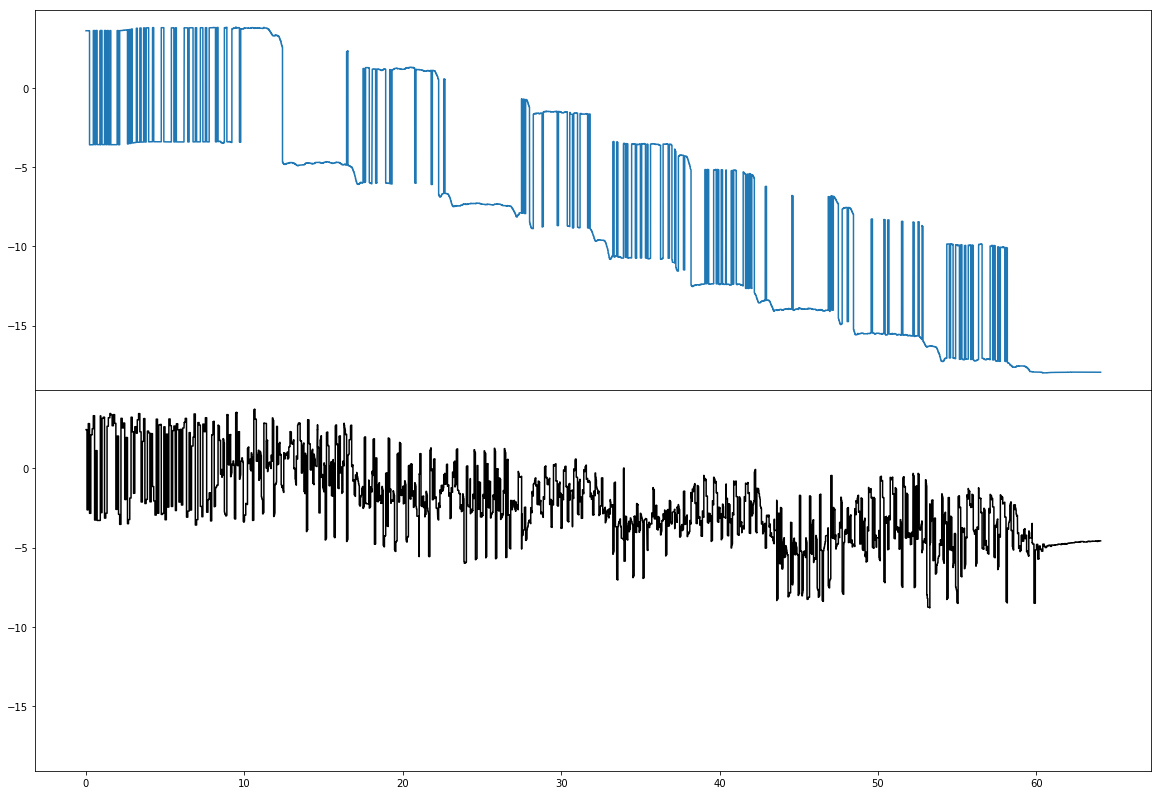

In [8]:
pr = pd.DataFrame(columns=['time','pitch','roll','pitch_cor', 'roll_cor'])
for _type in ['pitch', 'roll']:
    if _type == 'pitch':
        pr['{}'.format(_type)] = -np.arctan2(-data['az'], np.dot(data['az'], np.sqrt(np.square(data['ax'])+np.square(data['ay']))))*(180/np.pi)
    if _type == 'roll':
        pr['{}'.format(_type)] = -np.arctan2(-data['ax'], data['ay'])*(180/np.pi)
    pr['time'] = data['time']

for _type in ['pitch_cor', 'roll_cor']:
    if _type == 'pitch_cor':
        pr['{}'.format(_type)] = 0.98*int_1['wx_1']+0.02*pr['pitch']
    if _type == 'roll_cor':
        pr['{}'.format(_type)] = 0.98*int_1['wz_1']+0.02*pr['roll']

fig, (pitch, roll) = plt.subplots(2, sharex=True, sharey=True, figsize=(20,14))
pitch.plot(pr['time'], pr['pitch_cor'])
roll.plot(pr['time'], pr['roll_cor'], 'k-')
fig.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=False)
plt.show()

In [10]:
pitch_avg = np.mean(pr['pitch_cor'][:600])
roll_avg = np.mean(pr['roll_cor'][:600])
print (pitch_avg)
print (roll_avg)

-0.251948194555834
0.5782552431056925
